In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
from functools import reduce
import seaborn as sns
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib
from matplotlib.lines import Line2D 
import os
from sklearn import tree
from sklearn.metrics import mean_squared_error 
from dtreeviz.trees import dtreeviz 
from  matplotlib.cm import ScalarMappable
import warnings
warnings.filterwarnings('ignore')
# import pymc3 
from sklearn.preprocessing import PolynomialFeatures
from sklearn import linear_model
import scipy
from multiprocessing import Pool
from IIASA_22_fxns import get_N_exp, get_season_info, get_gs_climate, row_gsy_climate, tt_split_scale, random_forest, yield_run_data, all_run_data

In [3]:
# # simulation location data - X, Y, SimUID
loc = pd.read_csv("//Users//taraippolito//Desktop//Desktop_Tara’s_MacBook_Pro//EPIC_local//SimUID_Pts_210_240.txt", sep = ",")

# simulation units, all climate, site data - YEAR IS SEPARATE
obs_df = pd.read_csv("//Users//taraippolito//Desktop//Desktop_Tara’s_MacBook_Pro//EPIC_local//_SimUData//SimUID_static+clim.csv")

# Growing season climate variables 
GS_bau = pd.read_csv("//Users//taraippolito//Desktop//Desktop_Tara’s_MacBook_Pro//EPIC_local//CORN//C_BAU_R00_GSclim.csv") 
GS_n01 = pd.read_csv("//Users//taraippolito//Desktop//Desktop_Tara’s_MacBook_Pro//EPIC_local//CORN//C_N01_R00_GSclim.csv") 
GS_n50 = pd.read_csv("//Users//taraippolito//Desktop//Desktop_Tara’s_MacBook_Pro//EPIC_local//CORN//C_N50_R00_GSclim.csv") 
GS_n100 = pd.read_csv("//Users//taraippolito//Desktop//Desktop_Tara’s_MacBook_Pro//EPIC_local//CORN//C_N100_R00_GSclim.csv") 
GS_n250 = pd.read_csv("//Users//taraippolito//Desktop//Desktop_Tara’s_MacBook_Pro//EPIC_local//CORN//C_N250_R00_GSclim.csv") 


In [20]:
# list of growing season climate dataframes
GS_dfs = [GS_bau, GS_n01, GS_n50, GS_n100, GS_n250]

In [4]:
#### identify data subset to start with 
C = ["CORN"] 
N = ["BAU", "N01", "N50", "N100", "N250"]
# N = ["BAU"]
R = ["R00"]

In [5]:
#### Get season-specific info: start of season, end of season, length of season 
# pull arguments to feed into function in parallel
season_info_args = []
for c in C:
    for n in N: 
        for r in R: 
            season_info_args.append((c,n,r))

In [28]:
#### pull nitrogen added value, pull yield, pull annual mean change in carbon 
more_data_dfs = []

for arg in season_info_args: 
    more_data_dfs.append(all_run_data(arg))

starting variable loop.
FNO3  open.
Index(['SimUID', 'CROP', 'SCEN', 'YR', 'YLDG', 'YLDF', 'YLC', 'BIOM', 'RW',
       'FNO3_JAN', 'FNO3_FEB', 'FNO3_MAR', 'FNO3_APR', 'FNO3_MAY', 'FNO3_JUN',
       'FNO3_JUL', 'FNO3_AUG', 'FNO3_SEP', 'FNO3_OCT', 'FNO3_NOV', 'FNO3_DEC',
       'FNO3_AGG'],
      dtype='object')
FNO3  merged.
TOC  open.
Index(['SimUID', 'CROP', 'SCEN', 'YR', 'YLDG', 'YLDF', 'YLC', 'BIOM', 'RW',
       'FNO3_JAN', 'FNO3_FEB', 'FNO3_MAR', 'FNO3_APR', 'FNO3_MAY', 'FNO3_JUN',
       'FNO3_JUL', 'FNO3_AUG', 'FNO3_SEP', 'FNO3_OCT', 'FNO3_NOV', 'FNO3_DEC',
       'FNO3_AGG', 'TOC_JAN', 'TOC_FEB', 'TOC_MAR', 'TOC_APR', 'TOC_MAY',
       'TOC_JUN', 'TOC_JUL', 'TOC_AUG', 'TOC_SEP', 'TOC_OCT', 'TOC_NOV',
       'TOC_DEC', 'TOC_AGG'],
      dtype='object')
TOC  merged.
starting variable loop.
FNO3  open.
Index(['SimUID', 'CROP', 'SCEN', 'YR', 'YLDG', 'YLDF', 'YLC', 'BIOM', 'RW',
       'FNO3_JAN', 'FNO3_FEB', 'FNO3_MAR', 'FNO3_APR', 'FNO3_MAY', 'FNO3_JUN',
       'FNO3_JUL', 'FNO3_A

In [29]:
#### Calculate annual mean change in carbon 
for df in more_data_dfs:
    TOC_cols = [col for col in df.columns if "TOC" in col and "AGG" not in col]
    # calculate new columns that are differences between carbon columns 
    for i in range(len(TOC_cols) - 1): 
        new_col_name = "diff" + TOC_cols[i+1] +"-"+ TOC_cols[i] 
        df[new_col_name] = df[TOC_cols[i+1]] - df[TOC_cols[i]]
    df["mean_TOC_change"] = df[[col for col in df.columns if "diff" in col]].mean(axis = 1)
    print (df.SCEN.unique()[0], " calculated change in carbon.")

dyn_rf_BAU_R00  calculated change in carbon.
dyn_rf_N01_R00  calculated change in carbon.
dyn_rf_N50_R00  calculated change in carbon.
dyn_rf_N100_R00  calculated change in carbon.
dyn_rf_N250_R00  calculated change in carbon.


In [39]:
#### DROP COLUMNS USED IN CALCULATION 
for df in more_data_dfs: 
    df.reset_index(inplace = True)
    keep_cols = ['SimUID', 'CROP', 'SCEN', 'YR', 'YLDG', 'YLDF', 'YLC', 'BIOM', 'RW', 'FNO3_AGG', 'mean_TOC_change']
    drop_cols = [col for col in df.columns if col not in keep_cols]
    df.drop(drop_cols, axis = 1, inplace = True)

In [43]:
#### PULL ALL DATA PIECES TOGETHER
all_data_dfs = []

for i in range(len(GS_dfs)): 
    # pull appropriate data frames
    GS_df = GS_dfs[i]
    more_data_df = more_data_dfs[i]
    
    # pull site specific data 
    # One-hot encode the soil hydrological group 
    HSG_dummy = pd.get_dummies(obs_df.HSG2, prefix = "HSG")
    dummy_add = pd.concat([obs_df, HSG_dummy], axis = 1)

    # MERGE THE SEPARATE DATA PIECES TOGETHER 
    predictor_in = pd.merge(dummy_add, GS_df, how = "left", on = ["SimUID", "YR"]).drop(['Unnamed: 0_x', 'Unnamed: 0_y', 'SimU', 'NUTS2',
       'LCF3', 'HRU', 'ELEV_CAT', 'SLP_CAT', 'DTR', 'STONES',
       'ELEV', 'HSG2'], axis = 1)
    all_data = pd.merge(predictor_in, more_data_df, how = "left", on = ["SimUID", 'YR'])
    # remove records before 1986, reset index, drop nans
    all_data.drop(np.where(all_data.YR < 1986)[0], inplace = True)
    all_data.dropna(inplace=True)
    all_data.reset_index(drop = True, inplace = True)
    all_data_dfs.append(all_data)
    print (more_data_df.SCEN.unique()[0], " done.")

dyn_rf_BAU_R00  done.
dyn_rf_N01_R00  done.
dyn_rf_N50_R00  done.
dyn_rf_N100_R00  done.
dyn_rf_N250_R00  done.


In [45]:
#### DATAFRAME WITH ALL NITROGEN TREATMENTS
corn_r00 = pd.concat(all_data_dfs)

In [ ]:
corn_r00[(corn_r00.PRCPavGS > 100) & (corn_r00.PRCPskGS < 0) & (corn_r00.SAND_TOP > 60)]

(array([ 390830., 1160760.,  704310.,  436390.,  489770.,  718420.,
         664530., 1728035., 2349885., 2689735.,  683210.,  222435.,
          87040.,  144840.,  224740.,  326060.,  328530.,  583055.,
         469540.,  235110.]),
 array([ 6.   ,  9.755, 13.51 , 17.265, 21.02 , 24.775, 28.53 , 32.285,
        36.04 , 39.795, 43.55 , 47.305, 51.06 , 54.815, 58.57 , 62.325,
        66.08 , 69.835, 73.59 , 77.345, 81.1  ]),
 <BarContainer object of 20 artists>)

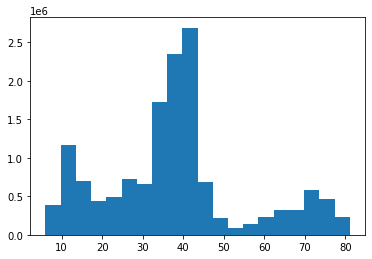

In [51]:
plt.hist(corn_r00.SAND_TOP, bins = 20)

In [ ]:
#### A PRIORI DATA CHOICE 
# low precipitation, left skewed precipitation, sandy soil 
cluster1 = all_data[(all_data.PRCPavGS < 40) & (all_data.PRCPskGS < 0) & (all_data.SAND_TOP > 60)]
print ("there are", len(cluster), "points in cluster 1.")

# low precipitation, left skewed precipitation, sandy soil 
cluster2 = all_data[(all_data.PRCPavGS > 100) & (all_data.PRCPskGS < 0) & (all_data.SAND_TOP > 60)]
print ("there are", len(cluster), "points in cluster 2.")

# low precipitation, left skewed precipitation, sandy soil 
cluster3 = all_data[(all_data.PRCPavGS < 40) & (all_data.PRCPskGS < 0) & (all_data.SAND_TOP < 40)]
print ("there are", len(cluster), "points in cluster 3.")

# low precipitation, left skewed precipitation, sandy soil 
cluster4 = all_data[(all_data.PRCPavGS > 100) & (all_data.PRCPskGS < 0) & (all_data.SAND_TOP > 40)]
print ("there are", len(cluster), "points in cluster 4.")